# 利用自编码器挖掘大量转录组冷胁迫相关基因

## 数据
- `data/cpm_filter.csv`: 转录组cpm矩阵
- `data/cold_Genes.txt`: 已知的参与冷胁迫响应基因

## 模型
采用自编码器结构，将基因的高维表达数据映射到二维，同时约束已知的冷胁迫响应基因在二维嵌入中具有较强的聚集性。根据二维嵌入聚类，挖掘潜在的冷胁迫响应基因


In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as Data
from tqdm import *

超参数设置

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCH = 20
BATCH_SIZE = 128
LR = 0.001
_a = 0.5  # 损失函数1 系数
_b = 0.5  # 损失函数2 系数
SAMPLE_NUM = BATCH_SIZE

原始数据预读

In [3]:
data = pd.read_csv("../data/cpm_filter.csv", index_col=0) # 转录组cpm矩阵
data_log = np.log(data+1)  # 转对数
data_norm = data_log.apply(lambda _x: (_x-np.min(_x) ) / (np.max(_x) - np.min(_x)))  # 0-1标准化

cold = list(open("../data/cold_Genes.txt", 'r').readlines())
cold = list(map(lambda _x: _x.strip(), cold)) # 冷胁迫的相关基因

genes = list(data_norm.index)
cold_index = []  # 冷胁迫基因索引
for i in range(len(genes)):
    if genes[i] in cold:
        cold_index.append(i)

自编码器设计

In [4]:
# 自编码器模型
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        self.encoder  =  nn.Sequential(
            nn.Linear(1511, 64),
            nn.Tanh(),
            nn.Linear(64, 16),
            nn.Tanh(),
            nn.Linear(16, 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.Tanh(),
            nn.Linear(16, 64),
            nn.Tanh(),
            nn.Linear(64, 1511),
            nn.Sigmoid()
        )
    def forward(self, _input):
        _encoded = self.encoder(_input)
        _decoded = self.decoder(_encoded)
        return _encoded, _decoded

数据加载与划分

In [5]:
data_com = data_norm.drop(data_norm.index[cold_index])  # 删除冷基因后的样本
data_cold = data_norm.iloc[cold_index]  # 冷基因样本

dx = torch.Tensor(np.array(data_com))
dataset = Data.TensorDataset(dx)
loader = Data.DataLoader(
    dataset = dataset,
    batch_size= BATCH_SIZE,
    shuffle=True,
    num_workers=1
)

def sample_cold_random(_data_cold:pd.DataFrame, num:int) -> torch.Tensor:
    """
    :param _data_cold: 所有冷基因的表达矩阵
    :param num: 取样数量
    :return: 采样的冷基因。类型张量
    """
    return torch.Tensor(np.array(data_cold.sample(num, replace=True)))

模型训练

In [6]:
Coder = AutoEncoder().to(device)
optimizer = torch.optim.Adam(Coder.parameters(),lr=LR)
loss_func1 = nn.MSELoss() # 损失函数1，自编码器约束解码结果与输入数据相似
loss_func2 = nn.MSELoss() # 损失函数2，附加约束冷响应基因在低维嵌入中具有聚集性

Coder.train()
for epoch in range(EPOCH):
    loop = tqdm(loader)
    for step, (x,)  in enumerate(loop):
        x = x.to(device)
        c = sample_cold_random(data_cold, SAMPLE_NUM).to(device)
        b = torch.cat((x, c), 0)
        center = torch.cat([torch.unsqueeze(torch.mean(c, 0), 0)]*len(c), 0)
        encoded , decoded = Coder(b)

        loss = _a * loss_func1(decoded, b) + _b * loss_func2(decoded[len(x):], center)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_description(f"Epoch [{epoch+1}/{EPOCH}]")
        loop.set_postfix(train_loss='%.8f'%loss.data)

torch.save(Coder,'AutoEncoder.pkl')
print('________________________________________')
print('finish training')

Epoch [20/20]: 100%|██████████| 176/176 [00:02<00:00, 62.21it/s, train_loss=0.00843819]

________________________________________
finish training


训练结果展示

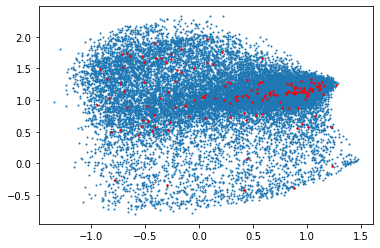

In [7]:
Coder = Coder.to('cpu')
e, d  = Coder(dx)
ed = np.array(e.detach())
plt.scatter(ed.T[0], ed.T[1], s = 1 , zorder = 1)
plt.scatter(ed[cold_index].T[0], ed[cold_index].T[1], s = 2 ,c='r', zorder = 2)
plt.show()
